# **Second Code**

✅ Cell 1: Install Dependencies

In [5]:
# Install specific versions
!pip install pytorch-lightning==2.4.0 pytorch-forecasting==1.4.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 867.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ Cell 2: Load and Prepare the Data

In [34]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/sample_data/dengue data 17-07-2025.csv")  # Change path if needed

# Convert date column
df['week_start_date'] = pd.to_datetime(df['week_start_date'])

# Filter only 'sj' city
df = df[df['city'] == 'sj'].copy()

# Fill missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Extract date features
df['month'] = df['week_start_date'].dt.month
df['day'] = df['week_start_date'].dt.day
df['dayofweek'] = df['week_start_date'].dt.dayofweek
df['year'] = df['week_start_date'].dt.year

# Convert city to categorical code
df['city'] = df['city'].astype('category').cat.codes

# Sort and create continuous time index
df = df.sort_values('week_start_date').reset_index(drop=True)
df['time_idx'] = df.index

/tmp/ipython-input-4022717451.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['week_start_date'] = pd.to_datetime(df['week_start_date'])
/tmp/ipython-input-4022717451.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-4022717451.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


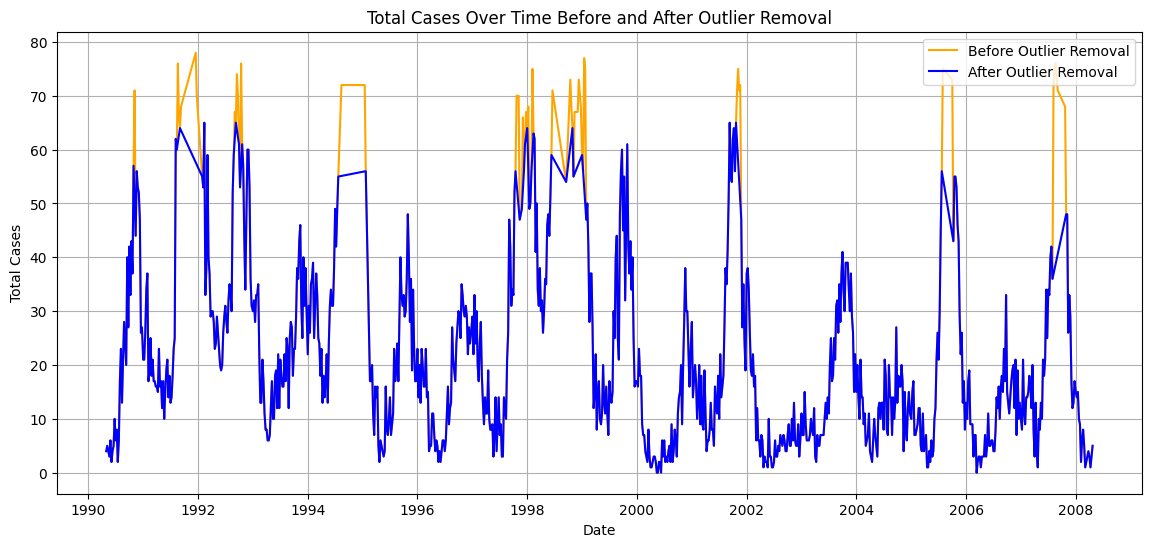

In [52]:

import matplotlib.pyplot as plt

# Plot total_cases over time before outlier removal
plt.figure(figsize=(14, 6))
plt.plot(df['week_start_date'], df['total_cases'], label='Before Outlier Removal', color='orange')

# Define IQR bounds
Q1 = df["total_cases"].quantile(0.25)
Q3 = df["total_cases"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_cleaned = df[(df["total_cases"] >= lower_bound) & (df["total_cases"] <= upper_bound)]

# Plot total_cases over time after outlier removal
plt.plot(df_cleaned['week_start_date'], df_cleaned['total_cases'], label='After Outlier Removal', color='blue')

plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.title('Total Cases Over Time Before and After Outlier Removal')
plt.legend()
plt.grid(True)
plt.show()

# Update df to cleaned data and reset time_idx
df = df_cleaned.sort_values("week_start_date").reset_index(drop=True)
df["time_idx"] = df.index


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   824 non-null    int8          
 1   year                                   824 non-null    int32         
 2   weekofyear                             824 non-null    int64         
 3   week_start_date                        824 non-null    datetime64[ns]
 4   ndvi_ne                                824 non-null    float64       
 5   ndvi_nw                                824 non-null    float64       
 6   ndvi_se                                824 non-null    float64       
 7   ndvi_sw                                824 non-null    float64       
 8   precipitation_amt_mm                   824 non-null    float64       
 9   reanalysis_air_temp_k                  824 non-null    float64   

✅ Cell 3: Train/Test Split

In [54]:
# 80/20 split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()
train_df["time_idx"]

,time_idx
0,0
1,1
2,2
3,3
4,4
...,...
654,654
655,655
656,656
657,657


✅ Cell 4: Prepare TimeSeriesDataSet

In [55]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning import seed_everything

seed_everything(42)

# Define features
features = [
    'city', 'year', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
    'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_tdtr_k',
    'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
    'station_min_temp_c', 'station_precip_mm', 'month', 'day', 'dayofweek'
]

target = 'total_cases'
max_encoder_length = 30
max_prediction_length = 10
training_cutoff = train_df["time_idx"].max() - max_prediction_length

# Create training dataset
training = TimeSeriesDataSet(
    train_df,#[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target,
    group_ids=["city"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"] + features,
    time_varying_unknown_reals=[target],
    target_normalizer=GroupNormalizer(groups=["city"]),
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, test_df, stop_randomization=True)


INFO:lightning_fabric.utilities.seed:Seed set to 42


✅ Cell 5: Create DataLoaders

In [56]:
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


✅ Cell 6: Define and Train TFT Model

In [68]:
# ✅ Cell 6: Define and Train TFT Model (consistent Lightning imports)

import lightning.pytorch as L
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
import torch

# (optional) a tiny perf tweak on CPU
torch.set_float32_matmul_precision("medium")

early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
lr_logger = LearningRateMonitor(logging_interval="epoch")

trainer = L.Trainer(
    max_epochs=30,
    gradient_clip_val=0.1,
    callbacks=[early_stop, lr_logger],
    accelerator="auto",   # will use CPU here (GPU not available)
    devices=1,
)

# Build TFT from the *training dataset*, not the dataloader
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.005,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=64,
    output_size=7,               # 7 quantiles
    loss=QuantileLoss(),         # required when using quantiles
    log_interval=10,
    reduce_on_plateau_patience=5
)

# Sanity check: should print True
print("Is LightningModule?", isinstance(tft, L.LightningModule))

trainer.fit(
    model=tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ig

Is LightningModule? True


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

✅ Cell 7: Evaluate the Model

In [58]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)

y_true = actuals.numpy()
y_pred = predictions.numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


MSE: 145.56
RMSE: 12.06
MAE: 8.29


✅ Cell 8: Plot Actual vs Predicted

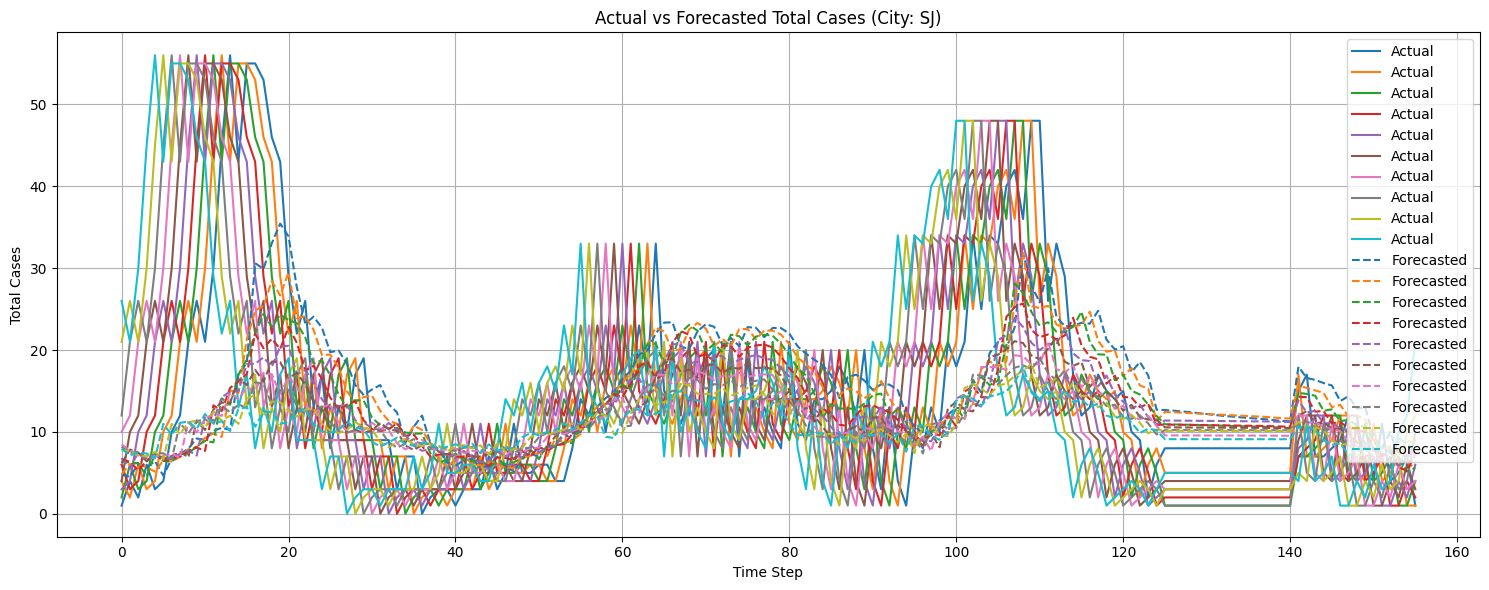

In [59]:
plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Forecasted', linestyle='--')
plt.title("Actual vs Forecasted Total Cases (City: SJ)")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


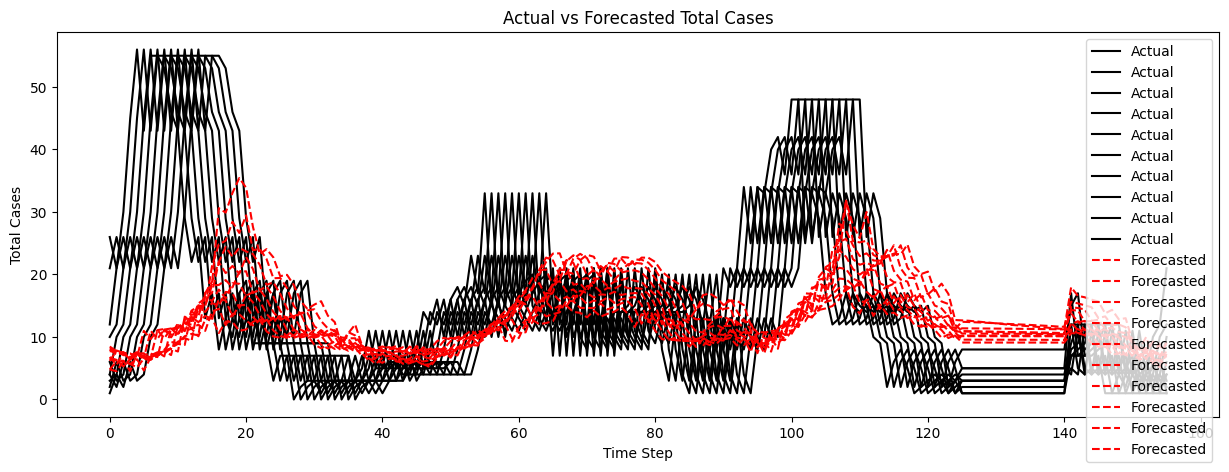

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose predictions.shape = (n_samples, prediction_length)
median_forecast = np.median(predictions, axis=0)  # median over samples

plt.figure(figsize=(15,5))
plt.plot(actuals, label="Actual", color="black")
plt.plot(predictions, label="Forecasted", linestyle="--", color="red")
plt.legend()
plt.title("Actual vs Forecasted Total Cases")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.show()


In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume:
# df has columns ['time_idx', 'total_cases']
# test_df is the held-out period
# predictions is TFT predictions aligned with test_df time_idx

# Make a copy of test_df with forecast column
forecast_df = test_df.copy()

# Ensure predictions are aligned with test_df time_idx
# Since predictions is a numpy array, we need to ensure its length matches test_df
if len(predictions) != len(test_df):
    # This is a simplified assumption: if the lengths don't match,
    # we'll just take the first len(test_df) predictions.
    # A more robust solution might involve matching time indices if they were available in predictions.
    print(f"Warning: Length of predictions ({len(predictions)}) does not match test_df ({len(test_df)}). Truncating predictions.")
    predictions = predictions[:len(test_df)]

# Select the median prediction for each time step
median_predictions = np.median(predictions, axis=1)

forecast_df["forecast"] = median_predictions  # predictions must match test_df length

plt.figure(figsize=(15,5))

# 1. Full actual data
plt.plot(actuals, label="Actual (Train+Test)", color="black", alpha=0.5)

# 2. Actual test data (highlighted)
plt.plot(test_df["total_cases"], label="Actual (Test)", color="blue")

# 3. Forecasted test data
plt.plot(predictions, label="Forecasted", color="red", linestyle="--")

plt.title("Actual vs Test vs Forecasted Total Cases")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.show()

ValueError: Length of values (156) does not match length of index (165)

In [62]:
# Get predictions, input, and actuals
y_pred, x, y_true = best_model.predict(val_dataloader, return_x=True, return_y=True)

# Convert to numpy
y_pred = y_pred.flatten().detach().cpu().numpy()
y_true = y_true.flatten().detach().cpu().numpy()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.plot(y_true, label="Actual", color="black")
plt.plot(y_pred, label="Forecasted", linestyle='--', color="red")
plt.title("Actual vs Forecasted Total Cases (City: SJ)")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: too many values to unpack (expected 3)

In [63]:
# Request prediction and actuals
predictions = best_model.predict(val_dataloader, return_x=True, return_y=True)

# Confirm what was returned
print(type(predictions))
print(dir(predictions))


<class 'pytorch_forecasting.models.base._base_model.Prediction'>
['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'decoder_lengths', 'get', 'iget', 'index', 'items', 'keys', 'output', 'x', 'y']


In [64]:
# Perform prediction
predictions = best_model.predict(val_dataloader, return_x=True, return_y=True)

# Extract forecasted predictions and actual future values
y_pred = predictions.output.flatten().detach().cpu().numpy()
y_true = predictions.y.flatten().detach().cpu().numpy()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.plot(y_true, label="Actual", color="black")
plt.plot(y_pred, label="Forecasted", linestyle='--', color="red")
plt.title("Actual vs Forecasted Total Cases (City: SJ)")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: 'tuple' object has no attribute 'flatten'

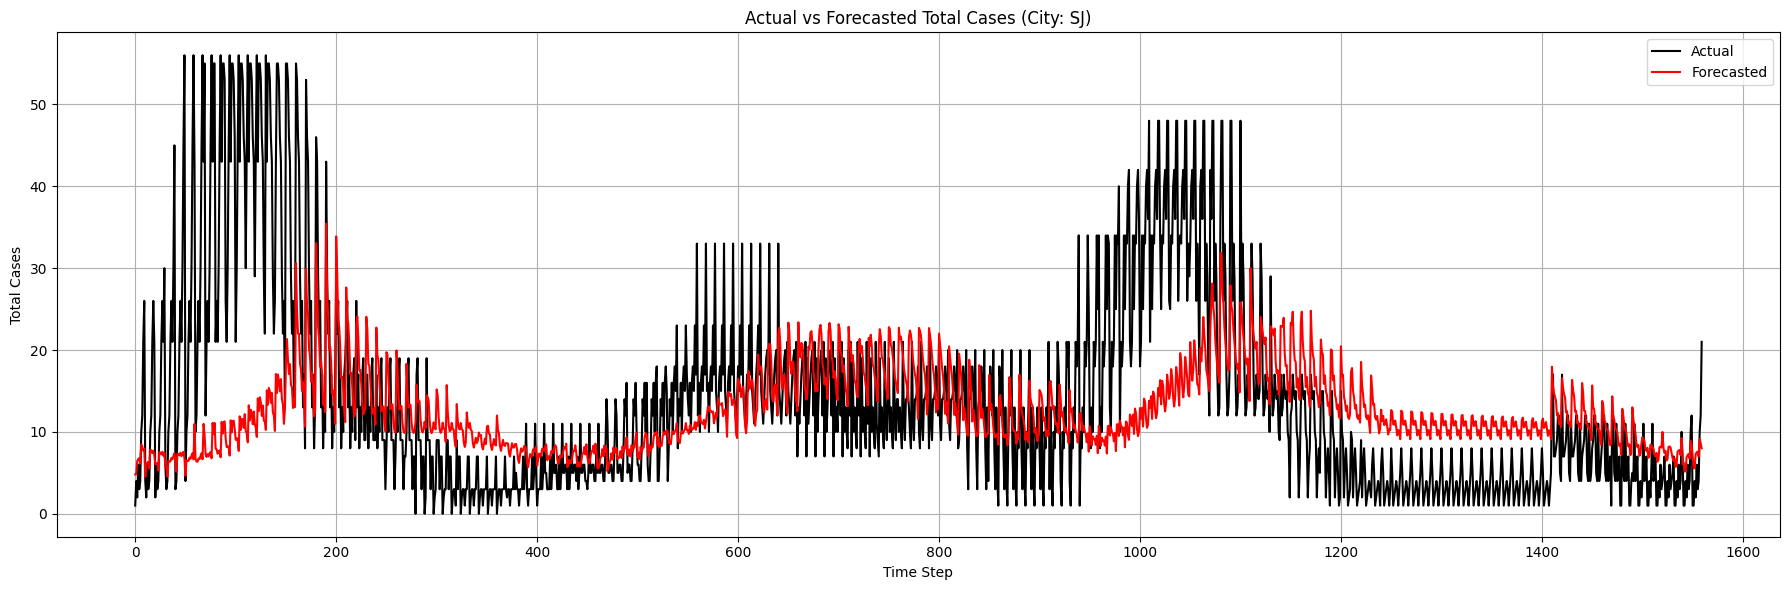

In [65]:
# Perform prediction
predictions = best_model.predict(val_dataloader, return_x=True, return_y=True)

# ✅ Extract forecasted predictions
y_pred = predictions.output.flatten().detach().cpu().numpy()

# ✅ Extract actual values (first element of the tuple)
y_true_tensor = predictions.y[0]  # predictions.y is a tuple: (actuals, weightings)
y_true = y_true_tensor.flatten().detach().cpu().numpy()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.plot(y_true, label="Actual", color="black")
plt.plot(y_pred, label="Forecasted", linestyle='-', color="red")
plt.title("Actual vs Forecasted Total Cases (City: SJ)")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (2219,) and (824,)

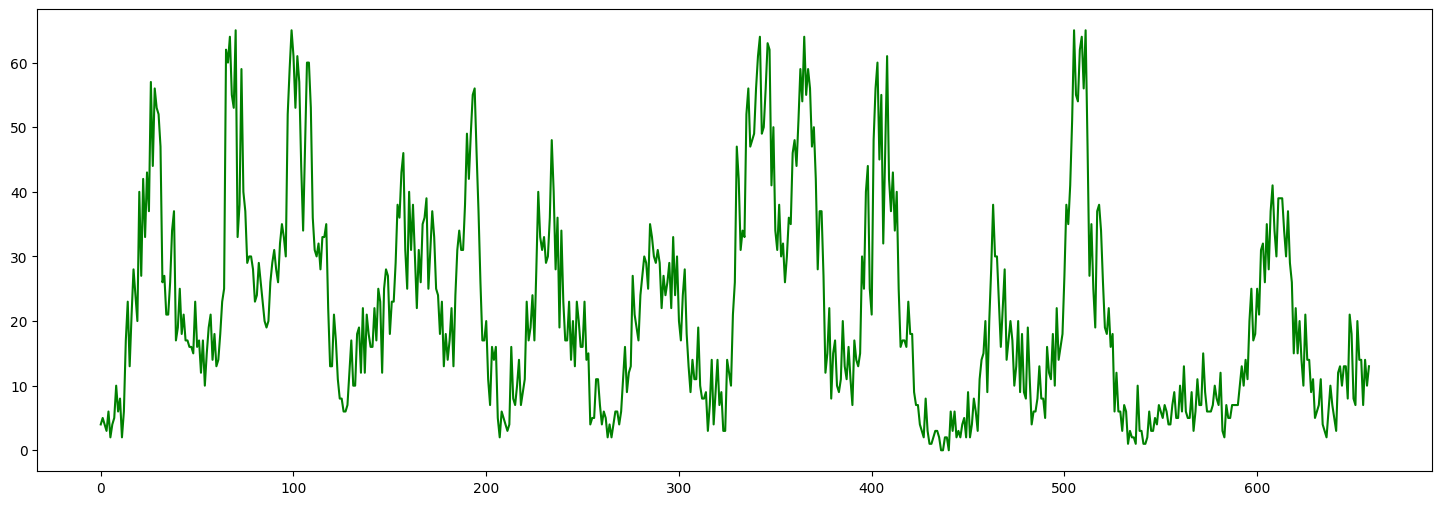

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Get training targets (true total_cases from train_df)
train_targets = train_df["total_cases"].values

# Trim to match forecast length
# In case prediction length is shorter than test set due to batching
forecast_length = len(y_pred)
test_targets = test_df["total_cases"].values[:forecast_length]

# Build full sequences
full_timeline = np.arange(len(train_targets) + forecast_length)
train_line = np.concatenate([train_targets, [np.nan]*forecast_length])
actual_line = np.concatenate([[np.nan]*len(train_targets), test_targets])
forecast_line = np.concatenate([[np.nan]*len(train_targets), y_pred])

# Plot all 3 lines
plt.figure(figsize=(18, 6))
plt.plot(full_timeline, train_line, label="Training Data", color="green")
plt.plot(full_timeline, actual_line, label="Actual Data", color="red")
plt.plot(full_timeline, forecast_line, label="Forecasted Data", color="blue", linestyle='--')

# Style
plt.title("Dengue Cases Forecast - City: SJ")
plt.xlabel("Time Step (Weeks)")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


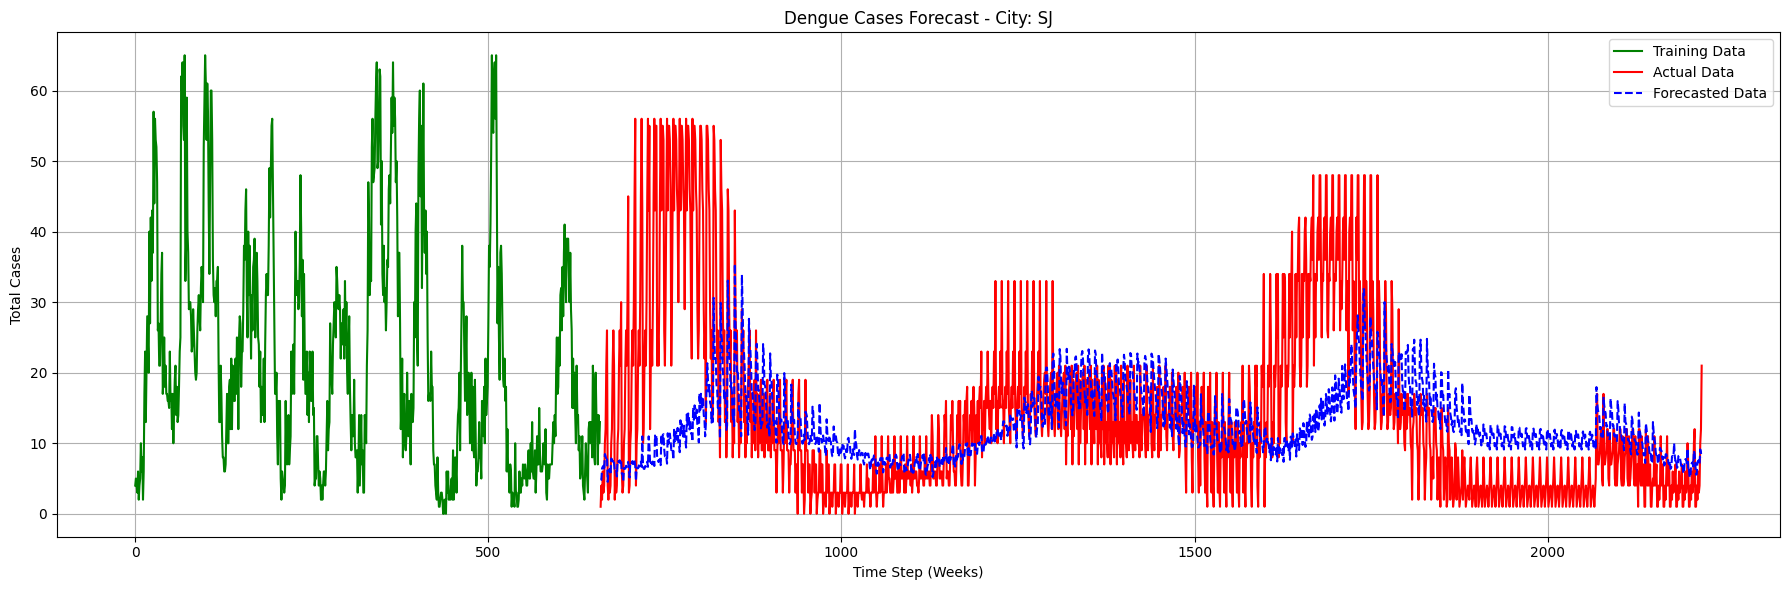

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Get training total cases
train_targets = train_df["total_cases"].values

# Get validation targets (trimmed to forecast length)
forecast_length = len(y_pred)
test_targets = test_df["total_cases"].values[:forecast_length]

# Trim in case actuals are longer than forecast
y_true_trimmed = y_true[:forecast_length]
y_pred_trimmed = y_pred[:forecast_length]

# Build timeline for full plot
full_length = len(train_targets) + forecast_length
full_timeline = np.arange(full_length)

# Build plot lines with NaNs in non-relevant areas
train_line = np.concatenate([train_targets, [np.nan]*forecast_length])
actual_line = np.concatenate([[np.nan]*len(train_targets), y_true_trimmed])
forecast_line = np.concatenate([[np.nan]*len(train_targets), y_pred_trimmed])

# Plot
plt.figure(figsize=(18, 6))
plt.plot(full_timeline, train_line, label="Training Data", color="green")
plt.plot(full_timeline, actual_line, label="Actual Data", color="red")
plt.plot(full_timeline, forecast_line, label="Forecasted Data", color="blue", linestyle='--')

# Style
plt.title("Dengue Cases Forecast - City: SJ")
plt.xlabel("Time Step (Weeks)")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
